### 株価取得

In [151]:
import pandas as pd


def electrical_companies():
    pages = 13
    df = pd.DataFrame()

    for page in range(1, pages + 1):
        url = 'https://profile.yahoo.co.jp/industry/electrical/electrical' + str(page) + '.html'
        tmp_df = pd.read_html(url)[2]
        
        df = pd.concat([df, tmp_df])

    df.drop(['関連情報'], axis='columns', inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df

In [152]:
import sys
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError


def get_historical(code):
    my_share = share.Share(str(code) + '.T')
    symbol_data = None

    try:
        symbol_data = my_share.get_historical(
            share.PERIOD_TYPE_MONTH,     # 期間 月
            6,                           # 期間 6カ月
            share.FREQUENCY_TYPE_DAY,    # 頻度 日
            1,                           # 頻度 1日毎
        )
    except YahooFinanceError as e:
        if e.message == 'Not Found: No data found, symbol may be delisted':
            print(f'error code: {code}')
        else:
            print(e.message)
            sys.exit(1)

    return symbol_data

In [154]:
df = electrical_companies()
df_h = pd.DataFrame()

for code in df['コード'].values:
    data = get_historical(code)
    if data:
        tmp_df = pd.DataFrame(data)
        tmp_df['code'] = code

        df_h = pd.concat([df_h, tmp_df])

error code: 6623
error code: 6655
error code: 6797
error code: 6846


In [ ]:
import datetime

df_h['datetime'] = pd.to_datetime(df_h.timestamp, unit='ms')
df_h['datetime_JST'] = df_h['datetime'] + datetime.timedelta(hours=9)
df_h.drop(['timestamp', 'datetime'], axis=1, inplace=True)
df_h.tail()

,open,high,low,close,volume,code,datetime_JST
115,58750.0,59180.0,58050.0,58700.0,1043600,8035,2022-05-23 09:00:00
116,58550.0,59130.0,58230.0,58230.0,967600,8035,2022-05-24 09:00:00
117,58600.0,59150.0,58170.0,58680.0,1010700,8035,2022-05-25 09:00:00
118,58210.0,58380.0,57010.0,57280.0,1324100,8035,2022-05-26 09:00:00
119,58550.0,59190.0,58330.0,59120.0,1258600,8035,2022-05-27 15:15:01


In [155]:
# df_h.to_csv('../data/electrical_stock_history.csv', index=False)
df_h = pd.read_csv('../data/electrical_stock_history.csv')

In [156]:
df_h.head()

,open,high,low,close,volume,code,datetime_JST
0,830.0,837.0,815.0,816.0,1822400,3105,2021-11-29 09:00:00
1,831.0,836.0,819.0,819.0,1984800,3105,2021-11-30 09:00:00
2,819.0,840.0,818.0,837.0,1184900,3105,2021-12-01 09:00:00
3,827.0,843.0,826.0,836.0,910600,3105,2021-12-02 09:00:00
4,834.0,848.0,832.0,847.0,942800,3105,2021-12-03 09:00:00


### 企業情報取得

In [ ]:
import numpy as np
import pyprind
import yahoo_fin.stock_info as si

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
code_list = np.unique(df_h['code'].values)
bar = pyprind.ProgBar(len(code_list), monitor=True)
df['総資産'] = 0

for code in code_list:
    market_cap = si.get_quote_table(str(code) + '.T')['Market Cap']
    char = market_cap[-1]

    unit = 0
    if char == 'M':
        unit = 1000000
    elif char == 'B':
        unit = 1000000000
    elif char == 'T':
        unit = 1000000000000
    df.loc[df['コード']==code, ['総資産']] = float(market_cap[:-1]) * unit

    bar.update()
print(bar)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:09:37


Title: 
  Started: 05/27/2022 01:39:08
  Finished: 05/27/2022 01:48:46
  Total time elapsed: 00:09:37
  CPU %: 4.40
  Memory %: 0.58


In [ ]:
# df.to_csv('../data/electrical_companies.csv', index=False)
df = pd.read_csv('../data/electrical_companies.csv')

### 可視化

In [201]:
df_h = pd.read_csv('../data/electrical_stock_history.csv')
df = pd.read_csv('../data/electrical_companies.csv')

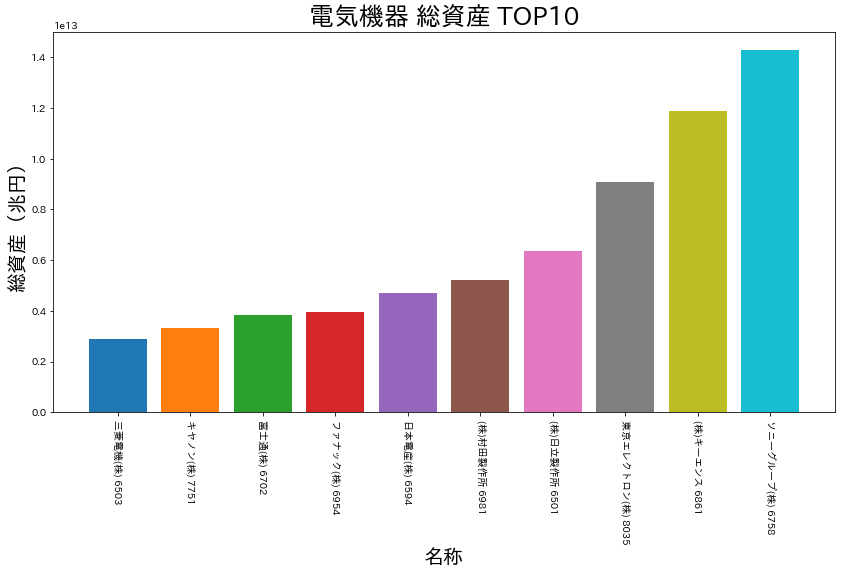

In [202]:
import matplotlib.pyplot as plt
import japanize_matplotlib

top_10_code = []
plt.figure(figsize=(14, 7))
for i, idx in enumerate(df.sort_values(['総資産'])[-10:].index):
    plt.bar(
        x=df.iloc[idx]['名 称'] + ' ' + str(df.iloc[idx]['コード']),
        height=df.iloc[idx]['総資産'],
    )
    top_10_code.append(df.iloc[idx]['コード'])

plt.xticks(rotation=270)
plt.xlabel('名称', size=20)
plt.ylabel('総資産（兆円）', size=20)
plt.title('電気機器 総資産 TOP10', size=25)
plt.show()

In [203]:
import numpy as np

def sma(values, n=3):
    sma = []
    for i, v in enumerate(values):
        if i < n:
            sma.append(np.nan)
            continue
        v = sum(values[i-n:i]) / n
        sma.append(v)
    return sma

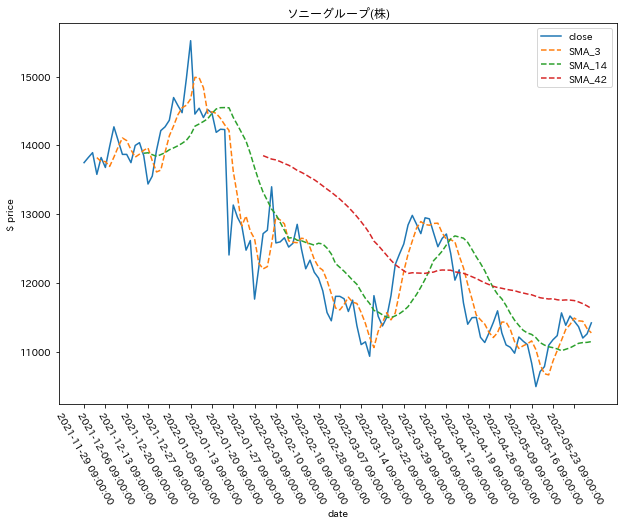

In [213]:
df_6758 = df_h.loc[df_h['code']==6758]
df_6758.set_index(['datetime_JST'], inplace=True)

sma_3 = sma(df_6758['close'].values, 3)
sma_14 = sma(df_6758['close'].values, 14)
sma_42 = sma(df_6758['close'].values, 42)

plt.figure(figsize=(10, 7))

plt.plot(df_6758.index, df_6758['close'], label='close')
plt.plot(df_6758.index, sma_3, linestyle='--', label='SMA_3')
plt.plot(df_6758.index, sma_14, linestyle='--', label='SMA_14')
plt.plot(df_6758.index, sma_42, linestyle='--', label='SMA_42')

plt.xticks([text for i, text in enumerate(df_6758.index) if i % 5 == 0], rotation=300)

plt.xlabel('date')
plt.ylabel('$ price')
plt.title(df.loc[df['コード']==top_10_code[-1]]['名 称'].values[0])
plt.legend(loc='upper right')
plt.show()

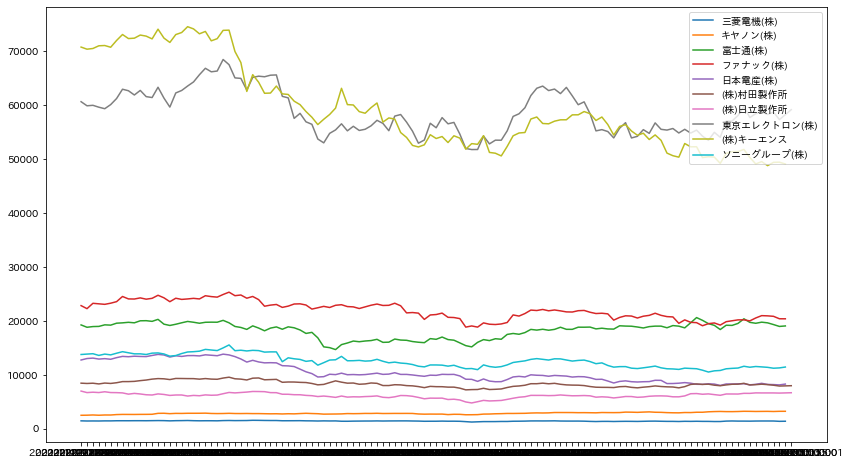

In [228]:
plt.figure(figsize=(14, 8))

for code in top_10_code:
    d = df_h.loc[df_h['code']==code]
    d.set_index(['datetime_JST'], inplace=True)

    plt.plot(d.index, d['close'], label=df.loc[df['コード']==code]['名 称'].values[0])

plt.legend(loc='upper right')
plt.show()